In [81]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [83]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=True,
    transform=transform)
print(' Number of training data ', len(trainset))

 Number of training data  60000


In [84]:
test_set = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=False,
    transform=transform)
print(' Number of testing data ',len(test_set))

 Number of testing data  10000


In [85]:
train_set, val_set = torch.utils.data.random_split(trainset, [50000, 10000])
print(' Number of final training data ', len(train_set))
print(' Number of validation data ', len(val_set))

 Number of final training data  50000
 Number of validation data  10000


In [86]:
BATCH_SIZE = 512

In [87]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

In [88]:
validationloader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

In [89]:
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [90]:
cnn_layers =  nn.Sequential(
            # Defining a 2D convolution layer
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            # in_channels (int) – Number of channels in the input image. For B&W it is 1.
            # out_channels (int) – Number of channels produced by the convolution. 4 filters
            # kernel_size (int or tuple) – Size of the convolving kernel (3x3)
            # stride (int or tuple, optional) – Stride of the convolution
            # padding (int or tuple, optional) – Padding of 1 added to both sides of the input
            # example x1 = (n, c=1 , h=28 , w=28 )
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1), #in_channels = 1 is a data dependent hyperparameter. It is 1 because the images are in grayscale
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.BatchNorm2d(4), # Normalize output from the activation function. 
            nn.ReLU(inplace=True), # negative elements to zero
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.MaxPool2d(kernel_size=2, stride=2), #Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on
            # x3 = (n, c=4 , h=14 , w=14 )
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.BatchNorm2d(4), # 4 features
            nn.ReLU(inplace=True), # inplace = True will modify the input directly, without allocating any additional output.
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.MaxPool2d(kernel_size=2, stride=2), # Downsamples the input representation by taking the maximum value
            # x4 = (n, c=4 , h=7 , w=7 )
        )
        # outputSize = floor[(inputSize - filterSize + 2 * padding) / stride] + 1
print(cnn_layers)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [91]:
linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10) 
#10 outputs because MNIST Fashion has 10 different classes. It is a data dependent hyperparameter
)

print(linear_layers)

Sequential(
  (0): Linear(in_features=196, out_features=10, bias=True)
)


In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layer = cnn_layers
        self.linear_layer = linear_layers
    
    def forward(self, x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.linear_layer(x)
        return x

In [93]:
net = Net()

In [94]:

optimizer =  optim.Adam(net.parameters(), lr=0.07) # learning rate 
# defining the loss function
criterion =  nn.CrossEntropyLoss()
# change loss function 
# 1. cross entropy 
# 2. 1 / (1 + distance between winning prob and second best prob)
# add 1 and 2 
# checking if GPU is available
if torch.cuda.is_available():
    print('cuda is available')
    net = net.cuda()
    criterion = criterion.cuda()

cuda is available


In [95]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([512, 1, 28, 28])


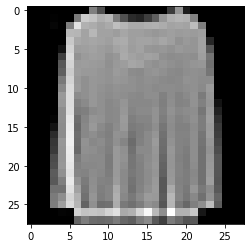

In [96]:
import numpy as np
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')

<Figure size 432x288 with 0 Axes>

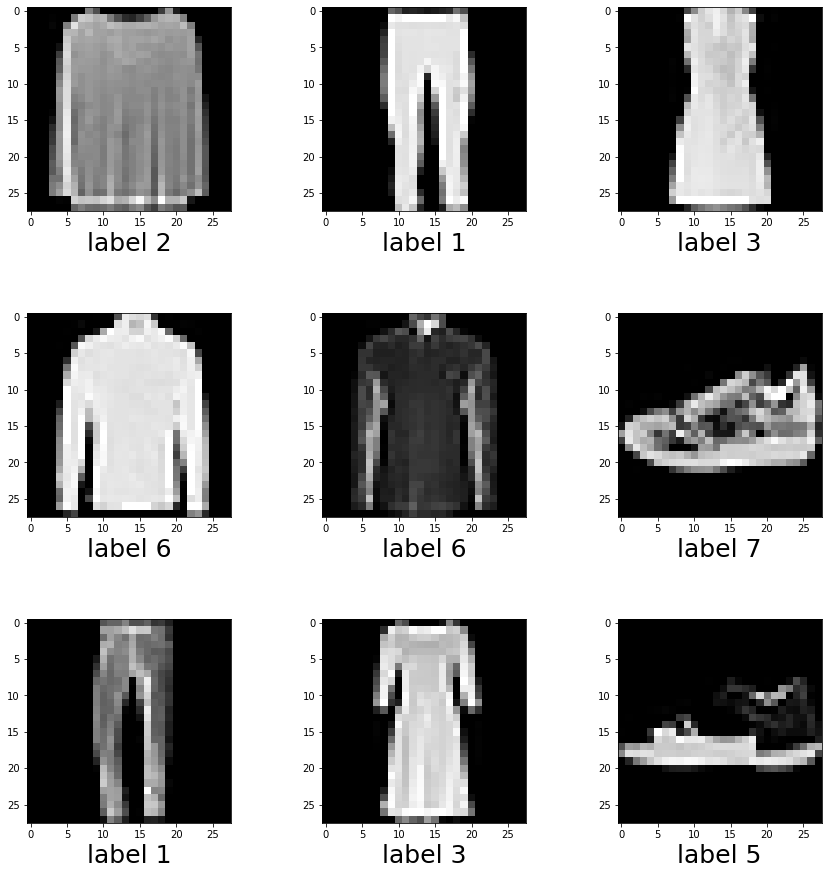

In [97]:
plt.figure()
plt_row = 3
plt_col = 3
fig, axes = plt.subplots(plt_row, plt_col, figsize=(15,15))
plt.subplots_adjust( hspace=0.5)
counter = 0
for i in range(plt_row):
    for j in range(plt_col):
        image = np.transpose(images[counter].numpy(), (1, 2, 0))
        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_xlabel("label {label}".format(label = labels[counter]),fontsize=25 )
        counter = counter + 1
plt.show()

In [98]:
def accuracy_finder(predictions , labels):
    softmax = torch.nn.Softmax(dim=1) 
    predictions = softmax(predictions)
    values, max_indices = torch.max(predictions, dim=1) 
    accuracy = ( max_indices == labels ).sum().item()/max_indices.size()[0]
    return accuracy

In [99]:
def validate():
    batches_traversed = 0 
    total_val_accuracy = 0
    total_val_loss = 0 
    for i, data in enumerate(validationloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        with torch.no_grad():
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_val_loss = total_val_loss + loss.item()
            val_accuracy = accuracy_finder(predictions=outputs, labels=labels)
        total_val_accuracy = total_val_accuracy + val_accuracy
        batches_traversed = batches_traversed + 1
    return (total_val_loss/batches_traversed, total_val_accuracy/batches_traversed)

In [106]:
def train(epochs:int , withCustomLoss = False):
    all_training_losses = []
    all_training_acc = []
    all_validation_losses = []
    all_validation_acc = []
    min_loss_at_epoch = -1
    global_min_average_loss = torch.tensor(999999999)
    # min average training loss = infinity 
    for epoch in range(epochs):  # loop over the dataset multiple times
        targets = []
        total_loss_epoch = 0
        total_acc_epoch = 0
        batches_traversed = 0 
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()
    

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            if withCustomLoss == True : 
                top_two_results = torch.topk(outputs,k=2, dim=1)
                loss = loss + 1/((top_two_results.values[:,0]-top_two_results.values[:,1]).sum())
            loss.backward()
            optimizer.step()
            targets.append(labels)
            total_loss_epoch = total_loss_epoch + loss.item()
            training_accuracy = accuracy_finder(predictions=outputs, labels=labels)
            total_acc_epoch = total_acc_epoch + training_accuracy
            batches_traversed = batches_traversed + 1 
        all_training_losses.append(total_loss_epoch/batches_traversed)
        all_training_acc.append(total_acc_epoch/batches_traversed)
        val_loss, val_acc = validate()
        all_validation_losses.append(val_loss)
        all_validation_acc.append(val_acc)
        print("epoch : {}, training loss : {}, training accuracy {},  validation loss : {}, validation accuracy {}".format(epoch+1,round((total_loss_epoch/batches_traversed),3),round((total_acc_epoch/batches_traversed),3), round(val_loss,3), round(val_acc,3)))
        #save the model with minimum training loss
        avg_training_loss_per_epoch = total_loss_epoch/batches_traversed
        # if min average training loss > avg_training_loss : min average training loss = avg_training_loss
        if global_min_average_loss > avg_training_loss_per_epoch:
            global_min_average_loss = avg_training_loss_per_epoch
            if withCustomLoss == True : 
                torch.save(net.state_dict(), "./custom_fmnist_min_loss_model.pth")
            else:
                torch.save(net.state_dict(), "./fmnist_min_loss_model.pth")
            min_loss_at_epoch = epoch
        # save the model 
        
    print('Finished Training')
    return (all_training_losses, all_training_acc, all_validation_losses, all_validation_acc, min_loss_at_epoch, global_min_average_loss)

In [114]:
training_loss, training_acc, val_loss, val_acc, min_loss_at_epoch, min_avg_loss = train(epochs=100)

epoch : 1, training loss : 0.305, training accuracy 0.889,  validation loss : 0.359, validation accuracy 0.877
epoch : 2, training loss : 0.297, training accuracy 0.892,  validation loss : 0.345, validation accuracy 0.879
epoch : 3, training loss : 0.29, training accuracy 0.894,  validation loss : 0.34, validation accuracy 0.885
epoch : 4, training loss : 0.293, training accuracy 0.893,  validation loss : 0.346, validation accuracy 0.878
epoch : 5, training loss : 0.292, training accuracy 0.893,  validation loss : 0.336, validation accuracy 0.883
epoch : 6, training loss : 0.288, training accuracy 0.895,  validation loss : 0.338, validation accuracy 0.884
epoch : 7, training loss : 0.295, training accuracy 0.893,  validation loss : 0.349, validation accuracy 0.874
epoch : 8, training loss : 0.288, training accuracy 0.895,  validation loss : 0.355, validation accuracy 0.873
epoch : 9, training loss : 0.291, training accuracy 0.894,  validation loss : 0.335, validation accuracy 0.879
epo

epoch : 75, training loss : 0.287, training accuracy 0.894,  validation loss : 0.34, validation accuracy 0.881
epoch : 76, training loss : 0.278, training accuracy 0.897,  validation loss : 0.338, validation accuracy 0.886
epoch : 77, training loss : 0.288, training accuracy 0.893,  validation loss : 0.375, validation accuracy 0.88
epoch : 78, training loss : 0.285, training accuracy 0.895,  validation loss : 0.327, validation accuracy 0.885
epoch : 79, training loss : 0.284, training accuracy 0.896,  validation loss : 0.341, validation accuracy 0.879
epoch : 80, training loss : 0.284, training accuracy 0.896,  validation loss : 0.336, validation accuracy 0.881
epoch : 81, training loss : 0.288, training accuracy 0.894,  validation loss : 0.359, validation accuracy 0.886
epoch : 82, training loss : 0.292, training accuracy 0.894,  validation loss : 0.373, validation accuracy 0.873
epoch : 83, training loss : 0.291, training accuracy 0.892,  validation loss : 0.36, validation accuracy 0

In [111]:
cus_training_loss, cus_training_acc, cus_val_loss, cus_val_acc,  cust_min_loss_at_epoch, cust_min_avg_loss = train(epochs=100, withCustomLoss=True)

epoch : 1, training loss : 0.344, training accuracy 0.876,  validation loss : 0.372, validation accuracy 0.869
epoch : 2, training loss : 0.346, training accuracy 0.876,  validation loss : 0.347, validation accuracy 0.881
epoch : 3, training loss : 0.332, training accuracy 0.88,  validation loss : 0.352, validation accuracy 0.876
epoch : 4, training loss : 0.335, training accuracy 0.88,  validation loss : 0.355, validation accuracy 0.877
epoch : 5, training loss : 0.33, training accuracy 0.881,  validation loss : 0.339, validation accuracy 0.88
epoch : 6, training loss : 0.33, training accuracy 0.88,  validation loss : 0.339, validation accuracy 0.88
epoch : 7, training loss : 0.323, training accuracy 0.882,  validation loss : 0.355, validation accuracy 0.877
epoch : 8, training loss : 0.322, training accuracy 0.884,  validation loss : 0.336, validation accuracy 0.884
epoch : 9, training loss : 0.319, training accuracy 0.885,  validation loss : 0.34, validation accuracy 0.881
epoch : 1

epoch : 75, training loss : 0.297, training accuracy 0.893,  validation loss : 0.342, validation accuracy 0.881
epoch : 76, training loss : 0.299, training accuracy 0.89,  validation loss : 0.356, validation accuracy 0.872
epoch : 77, training loss : 0.291, training accuracy 0.893,  validation loss : 0.332, validation accuracy 0.884
epoch : 78, training loss : 0.29, training accuracy 0.893,  validation loss : 0.356, validation accuracy 0.876
epoch : 79, training loss : 0.287, training accuracy 0.896,  validation loss : 0.338, validation accuracy 0.883
epoch : 80, training loss : 0.299, training accuracy 0.89,  validation loss : 0.334, validation accuracy 0.883
epoch : 81, training loss : 0.292, training accuracy 0.893,  validation loss : 0.351, validation accuracy 0.873
epoch : 82, training loss : 0.294, training accuracy 0.893,  validation loss : 0.348, validation accuracy 0.885
epoch : 83, training loss : 0.295, training accuracy 0.893,  validation loss : 0.353, validation accuracy 0

In [138]:
cust_min_loss_at_epoch

78

In [139]:
cust_min_avg_loss

0.28715390955307046

In [117]:
PATH = './fmnist_test.pth'
#saving model
torch.save(net.state_dict(), PATH)

In [118]:
print(len(training_loss))
print(len(training_acc))
print(len(val_loss))
print(len(val_acc))

100
100
100
100


In [119]:
def convert_to_tensor_from_list_of_tensors(values):
    try:
        try: 
            values = torch.cuda.FloatTensor(values)
        except: 
            values = torch.FloatTensor(values)
    except: 
        print('an exception occured')
    return values

In [132]:
loss = convert_to_tensor_from_list_of_tensors(training_loss)
acc = convert_to_tensor_from_list_of_tensors(training_acc)
v_loss = convert_to_tensor_from_list_of_tensors(val_loss) 
v_acc = convert_to_tensor_from_list_of_tensors(val_acc)

In [133]:
custom_loss = convert_to_tensor_from_list_of_tensors(cus_training_loss)
custom_acc = convert_to_tensor_from_list_of_tensors(cus_training_acc)
custom_v_loss = convert_to_tensor_from_list_of_tensors(cus_val_loss) 
custom_v_acc = convert_to_tensor_from_list_of_tensors(cus_val_acc)

In [143]:
def result_plot(v_value , t_value, title,ylabel):
    v_value = v_value.cpu().numpy()
    t_value = t_value.cpu().numpy()
    plt.plot(v_value,'r')
    plt.plot(t_value,'b')
    plt.title(title)
    if ylabel =="loss":
        plt.plot(cust_min_loss_at_epoch,cust_min_avg_loss, 'xb')
    plt.legend(("validation","training"))
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.show()

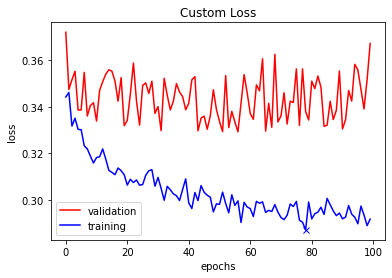

In [144]:
result_plot(v_value= custom_v_loss ,t_value= custom_loss, title="Custom Loss", ylabel="loss" )

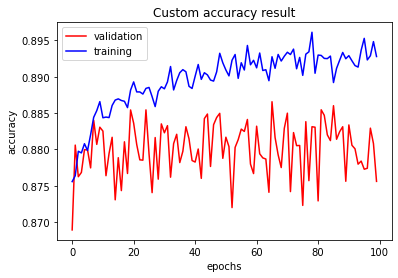

In [145]:
result_plot(v_value= custom_v_acc ,t_value= custom_acc,title="Custom accuracy result", ylabel="accuracy")

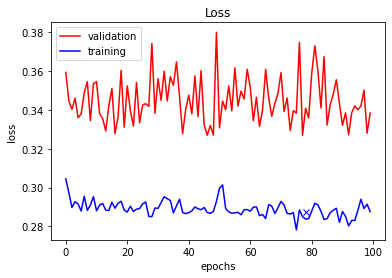

In [146]:
result_plot(v_value= v_loss ,t_value= loss, title="Loss", ylabel="loss" )

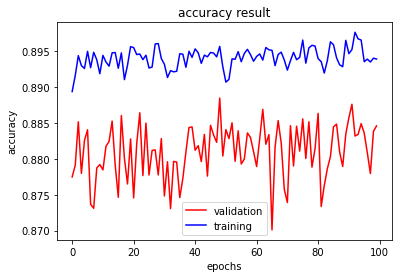

In [147]:
result_plot(v_value= v_acc ,t_value= acc,title="accuracy result", ylabel="accuracy")